<a href="https://colab.research.google.com/github/shivammehta007/QuestionGenerator/blob/master/Classifier_to_detect_type_of_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Classifier Model

In [1]:
# Essential Installation for working of notebook
!pip install -U tqdm

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.43.0)


### Imports

In [0]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from tqdm.auto import tqdm, trange
from wordcloud import WordCloud
from xgboost import XGBClassifier

### Environment Setup 

In [0]:
SEED=1234
def seed_all(seed=1234):
    """Seed the results for duplication"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_all(SEED)

In [0]:
tqdm.pandas()
nlp = spacy.load("en_core_web_sm") 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATASET_LOCATION = '/content/drive/My Drive/Data/GrammarDataset.csv'

## Dataset Overview

In [0]:
original_dataset = pd.read_csv(DATASET_LOCATION, sep="\t")

In [8]:
original_dataset.head()

,Question,key,answer,Type of Question,Sub Section
0,She _________________ some chocolates to the p...,bring,She brought some chocolates to the party.,irregular verb,past simple
1,I _________________ a new song on the radio.,hear,I heard a new song on the radio.,irregular verb,past simple
2,I _________________ three books last week.,read,I read three books last week.,irregular verb,past simple
3,They _________________ French to the waitress.,speak,They spoke French to the waitress.,irregular verb,past simple
4,He _________________ during the class but now ...,understand,He understood during the class but now he doe...,irregular verb,past simple


In [9]:
original_dataset.dtypes

Question            object
key                 object
answer              object
Type of Question    object
Sub Section         object
dtype: object

#### EDA

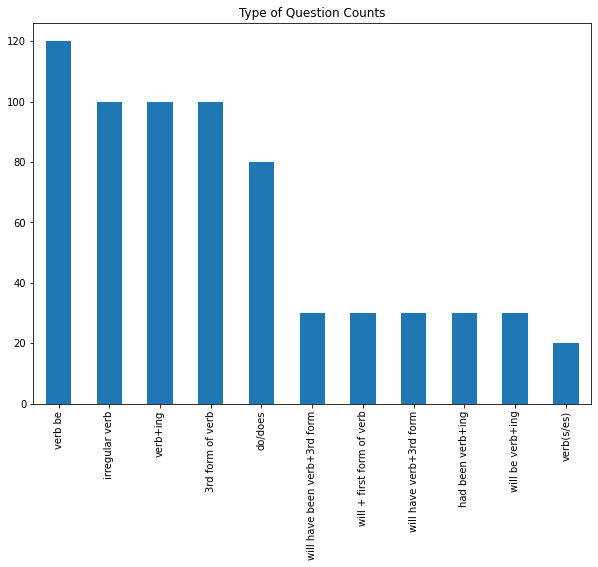

In [10]:
ax, fig = plt.subplots(figsize=(10, 7))
question_class = original_dataset["Type of Question"].value_counts()
question_class.plot(kind='bar')
plt.title('Type of Question Counts')
plt.show()

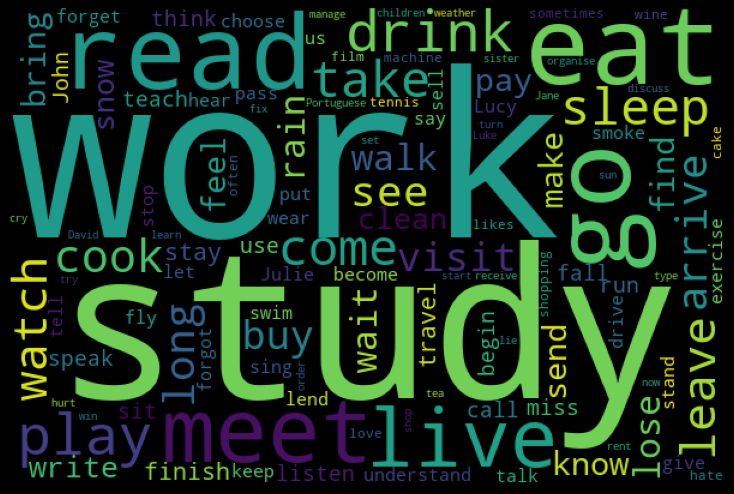

In [11]:
insincere_wordcloud = WordCloud(width=600, height=400).generate(" ".join(original_dataset["key"]))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(insincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### PreProcessing

In [0]:
def preprocessor(dataset):
    # Replace continuous underscores with single one
    dataset["Question"] = dataset["Question"].str.replace("[_]{2,}", "_")
    # Remove Brackets
    dataset["Question"] = dataset["Question"].str.replace("[\)\(]", "")
    # Strip whitespaces
    dataset["Question"] = dataset["Question"].apply(lambda x: x.strip())
    # Convert all text to lowercase
    for columns in dataset.columns:
        dataset[columns] = dataset[columns].str.lower() 

    return dataset

In [0]:
original_dataset = preprocessor(original_dataset)

In [14]:
original_dataset.columns

Index(['Question', 'key', 'answer', 'Type of Question', 'Sub Section'], dtype='object')

#### Encoding Labels

In [0]:
label_encoder = LabelEncoder()
original_dataset["Type of Question"] = label_encoder.fit_transform(original_dataset["Type of Question"])

#### Split Training and Testing Data

In [0]:
X_train_orig_dataset, X_test_orig_dataset, y_train_orig_dataset, y_test_orig_dataset = train_test_split(original_dataset[["Question", "key", "answer"]], original_dataset["Type of Question"], random_state=SEED, test_size=0.15)

In [17]:
X_train_orig_dataset.shape, X_test_orig_dataset.shape, y_train_orig_dataset.shape, y_test_orig_dataset.shape

((569, 3), (101, 3), (569,), (101,))

## Experiments:

In [18]:
X_train_orig_dataset.head()

,Question,key,answer
271,how / they / get to work?,they,how do they get to work?
488,we were late for the plane because we _our pas...,forgot,we were late for the plane because we had forg...
131,we _ thirsty.,be,we aren't thirsty.
643,"he_, so the kitchen will be warm.",cook,"he will have been cooking, so the kitchen will..."
155,you / in a cafe?,be,are you in a cafe?


### Experimentation Setup

#### Models

In [0]:
text_vectorizers = [
                    ('CountVectorizer', CountVectorizer()), 
                    ('TfIdFVectorize', TfidfVectorizer())
                ]
classifiers = [
               ('MultiNomial Naive Bais', MultinomialNB(alpha=0.1)),
               ('LogisticRegression', LogisticRegression(max_iter=5000)), 
               ('SVM', SVC()), ('RandomForest', RandomForestClassifier()), 
               ('XGBClassifier', XGBClassifier(random_state=SEED, learning_rate=0.01))
            ]

In [0]:
def check_classification(X_train, y_train, X_test, y_test):

    # Result DataFrame
    result_dataframe = pd.DataFrame({
        'Vectorizer': [name for name, model in text_vectorizers]
        }, columns = ['Vectorizer'] + [name for name, model in classifiers])
    result_dataframe.set_index('Vectorizer', inplace=True)


    best_score = 0
    best_model = None
    for classifier_name, classifier in classifiers:
        for text_vectorizer_name, text_vectorizer in text_vectorizers:
            pipe = Pipeline(steps=[
                                ('text_vec', text_vectorizer),
                                ('class', classifier)
            ])
            pipe.fit(X_train, y_train)
            f1_measure = f1_score(pipe.predict(X_test), y_test, average='micro')
            # print('Model : {} -> {}:  accuracy: {:.4f}'.format(text_vectorizer_name, classifier_name, acc*100))

            result_dataframe[classifier_name][text_vectorizer_name] = '{:.4f}'.format(f1_measure)

            if f1_measure > best_score:
                best_score = f1_measure
                best_model = '{} -> {}'.format(text_vectorizer_name, classifier_name)


    print("\n\nBest Accuracy was : {:.4f} with the Model: {}".format(best_score*100, best_model))
    return result_dataframe

#### Result Placeholder

In [0]:
result_dataframe = pd.DataFrame({
        'Vectorizer': [name for name, model in text_vectorizers]
        }, columns = ['Vectorizer'] + [name for name, model in classifiers])
result_dataframe.set_index('Vectorizer', inplace=True)

results = []

#### N-Gram Generator

In [0]:
from itertools import cycle
from collections import deque

def ngrams(sentence, n=2):
    words = [word.text for word in nlp(sentence)]
    d = deque(maxlen=n)
    d.extend(words[:n])
    words = words[n:]
    results = []
    for window, word in zip(cycle((d,)), words):
        results.extend([ngram for ngram in window])
        d.append(word)
    results.extend([ngram for ngram in d])

    return results


In [23]:
for n in range(2,5):
    print(" {}-Grams:".format(n), end=" ")
    print(ngrams("Hello World! This is a test example of N-Gram generator", n))

 2-Grams: ['Hello', 'World', 'World', '!', '!', 'This', 'This', 'is', 'is', 'a', 'a', 'test', 'test', 'example', 'example', 'of', 'of', 'N', 'N', '-', '-', 'Gram', 'Gram', 'generator']
 3-Grams: ['Hello', 'World', '!', 'World', '!', 'This', '!', 'This', 'is', 'This', 'is', 'a', 'is', 'a', 'test', 'a', 'test', 'example', 'test', 'example', 'of', 'example', 'of', 'N', 'of', 'N', '-', 'N', '-', 'Gram', '-', 'Gram', 'generator']
 4-Grams: ['Hello', 'World', '!', 'This', 'World', '!', 'This', 'is', '!', 'This', 'is', 'a', 'This', 'is', 'a', 'test', 'is', 'a', 'test', 'example', 'a', 'test', 'example', 'of', 'test', 'example', 'of', 'N', 'example', 'of', 'N', '-', 'of', 'N', '-', 'Gram', 'N', '-', 'Gram', 'generator']


#### Sample Generator

In [0]:
def get_input_samples(X, y, n=5):
    results = []
    for i in random.sample(range(len(X) - 1), n):
        results.append("{} --> {} ".format(X.iloc[i], label_encoder.inverse_transform([y.iloc[i]])))

    return results

### Experiment 1:  Words
Concatenating Question + key + answer in a Bag Of Words Approach \\
No Feature Engineering

In [0]:
experiment_text = "Concatenating question + key + answer."

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"] + " " + X_train_orig_dataset["key"] + " " + X_train_orig_dataset["answer"]
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"] + " " + X_test_orig_dataset["key"] + " " + X_test_orig_dataset["answer"]
y_test = y_test_orig_dataset

#### Input Samples

In [27]:
get_input_samples(X_train, y_train)

["they _ so we went to a restaurant. not eat they hadn't eaten so we went to a restaurant. --> ['3rd form of verb'] ",
 "when / you / leave? you leave when are you leaving? --> ['verb+ing'] ",
 "they / live in london live they live in london. --> ['verb(s/es)'] ",
 "_ football when he was injured? how long he play how long had he been playing football when he was injured? --> ['had been verb+ing'] ",
 "_ the film already? she see had she seen the film already? --> ['3rd form of verb'] "]

#### Experimentation Results

In [28]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best Accuracy was : 92.0792 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6535,0.8119,0.5842,0.9208,0.8911
TfIdFVectorize,0.6436,0.6436,0.6139,0.8812,0.8317


### Experiment 2: Word#POS
With POS Tags

In [0]:
experiment_text = "Adding Pos Tags along with q#tags + k#tags + a#tags Unigrams"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"] + " " + X_train_orig_dataset["key"] + " " + X_train_orig_dataset["answer"]
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"] + " " + X_test_orig_dataset["key"] + " " + X_test_orig_dataset["answer"]
y_test = y_test_orig_dataset

In [31]:
def add_pos_tagging(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("{}#{}".format(token.text, token.pos_))

    return " ".join(text)

# Testing method
test_sentence = "Testing the Pos Tagger in this sentence let's see how it works!".lower()
add_pos_tagging(test_sentence)

"testing#VERB the#DET pos#NOUN tagger#NOUN in#ADP this#DET sentence#NOUN let#VERB 's#PRON see#VERB how#ADV it#PRON works#VERB !#PUNCT"

In [32]:
X_train = X_train.progress_apply(add_pos_tagging)
X_test = X_test.progress_apply(add_pos_tagging)

#### Input Samples

In [33]:
get_input_samples(X_train, y_train)

["she#PRON /#SYM love#NOUN chocolate#NOUN love#NOUN she#PRON loves#VERB chocolate#NOUN .#PUNCT --> ['verb(s/es)'] ",
 "what#PRON /#PUNCT that#DET noise#NOUN /#PUNCT be#AUX ?#PUNCT be#AUX what#PRON was#AUX that#DET noise#NOUN ?#PUNCT --> ['verb be'] ",
 "_#PROPN tomorrow#NOUN ?#PUNCT they#PRON come#VERB will#VERB they#PRON come#VERB tomorrow#NOUN ?#PUNCT --> ['will + first form of verb'] ",
 "where#ADV /#PUNCT we#PRON ?#PUNCT be#AUX  #SPACE where#ADV are#AUX we#PRON ?#PUNCT --> ['verb be'] ",
 "she#PRON /#SYM eat#VERB chocolate#NOUN eat#VERB she#PRON 's#AUX eating#VERB chocolate#NOUN .#PUNCT --> ['verb+ing'] "]

#### Experimentation Results

In [34]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best Accuracy was : 98.0198 with the Model: CountVectorizer -> XGBClassifier


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7030,0.8317,0.6832,0.9703,0.9802
TfIdFVectorize,0.6535,0.6535,0.6535,0.9109,0.9307


### Experiment 3: Word#(q/k/a)
With Question, Key, Answer Tagging

In [0]:
experiment_text = "Tagging word with q, k, a example: word#q + word#k + word#a"

#### Preprocessing

In [0]:
def add_tag(text, tag):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("{}#{}".format(token.text, tag))
    
    return " ".join(text)

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_tag(x, "q")) + " " + X_train_orig_dataset["key"].apply(lambda x: add_tag(x, "k")) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_tag(x, "a"))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_tag(x, "q")) + " " + X_test_orig_dataset["key"].apply(lambda x: add_tag(x, "k")) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_tag(x, "a"))
y_test = y_test_orig_dataset

#### Input Samples

In [38]:
get_input_samples(X_train, y_train)

["what#q _#q by#q the#q end#q of#q the#q day#q ?#q you#k do#k what#a will#a you#a have#a done#a by#a the#a end#a of#a the#a day#a ?#a --> ['will have verb+3rd form'] ",
 "i#q /#q not#q /#q like#q coffee#q not#k i#a do#a n't#a like#a coffee#a .#a --> ['do/does'] ",
 "who#q /#q the#q teacher#q /#q be#q ?#q be#k who#a was#a the#a teacher#a ?#a --> ['verb be'] ",
 "what#q time#q _#q today#q ?#q the#k sun#k set#k what#a time#a will#a the#a sun#a set#a today#a ?#a --> ['will + first form of verb'] ",
 "she#q _#q under#q the#q tree#q to#q shelter#q from#q the#q rain#q .#q stand#k she#a stood#a under#a the#a tree#a to#a shelter#a from#a the#a rain#a .#a --> ['irregular verb'] "]

#### Experimentation Results

In [39]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best Accuracy was : 95.0495 with the Model: CountVectorizer -> XGBClassifier


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6733,0.8218,0.6733,0.9406,0.9505
TfIdFVectorize,0.6436,0.6337,0.6238,0.8812,0.9109


### Experiment 4: Word#POS#(q/k/a)
POS Tagger with q,k,a tagging

In [0]:
experiment_text = "Adding POS Tagging and qka tagging example: word#tag#q word#tag#k word#tag#a"

#### Preprocessing

In [0]:
def add_tag_and_pos(text, tag):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("{}#{}#{}".format(token.text, token.pos_, tag))

    return " ".join(text)

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_tag_and_pos(x, "q")) + " " + X_train_orig_dataset["key"].apply(lambda x: add_tag_and_pos(x, "k")) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_tag_and_pos(x, "a"))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_tag_and_pos(x, "q")) + " " + X_test_orig_dataset["key"].apply(lambda x: add_tag_and_pos(x, "k")) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_tag_and_pos(x, "a"))
y_test = y_test_orig_dataset

#### Input Samples

In [43]:
get_input_samples(X_train, y_train)

["mrs#PROPN#q .#PROPN#q brown#PROPN#q /#PUNCT#q not#PART#q /#SYM#q walk#NOUN#q in#ADP#q the#DET#q garden#NOUN#q when#ADV#q the#DET#q murder#NOUN#q happened#VERB#q not#PART#k walk#VERB#k mrs#PROPN#a .#PROPN#a brown#PROPN#a was#AUX#a n't#PART#a walking#VERB#a in#ADP#a the#DET#a garden#NOUN#a .#PUNCT#a --> ['verb+ing'] ",
 "she#PRON#q told#VERB#q me#PRON#q that#SCONJ#q she#PRON#q _#PROPN#q a#DET#q lot#NOUN#q before#ADP#q the#DET#q exam#NOUN#q .#PUNCT#q study#NOUN#k she#PRON#a told#VERB#a me#PRON#a that#SCONJ#a she#PRON#a had#AUX#a studied#VERB#a a#DET#a lot#NOUN#a before#ADP#a the#DET#a exam#NOUN#a .#PUNCT#a --> ['3rd form of verb'] ",
 "lucy#PROPN#q /#PUNCT#q not#PART#q /#SYM#q do#AUX#q /#PUNCT#q her#DET#q homework#NOUN#q not#PART#k do#AUX#k lucy#PROPN#a has#AUX#a n't#PART#a done#VERB#a her#DET#a homework#NOUN#a .#PUNCT#a --> ['3rd form of verb'] ",
 "she#PRON#q said#VERB#q that#SCONJ#q she#PRON#q _#PROPN#q the#DET#q uk#PROPN#q before#ADV#q .#PUNCT#q not#PART#k visit#VERB#k she#PRON#a sa

#### Experimentation Results

In [44]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best Accuracy was : 98.0198 with the Model: CountVectorizer -> XGBClassifier


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7228,0.8416,0.6733,0.9505,0.9802
TfIdFVectorize,0.6634,0.6634,0.6238,0.9208,0.9208


### Experiment 5: Word#POS#(q/k/a) Bi Grams
POS Tagger with q,k,a tagging

In [0]:
experiment_text = "Adding POS Tagging and qka tagging example: word#tag#q word#tag#k word#tag#a Bi Grams with same convention"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_tag_and_pos(x, "q")) + " " + X_train_orig_dataset["key"].apply(lambda x: add_tag_and_pos(x, "k")) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_tag_and_pos(x, "a"))
X_train = X_train.apply(lambda x: " ".join(ngrams(x)))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_tag_and_pos(x, "q")) + " " + X_test_orig_dataset["key"].apply(lambda x: add_tag_and_pos(x, "k")) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_tag_and_pos(x, "a"))
X_test = X_test.apply(lambda x: " ".join(ngrams(x)))
y_test = y_test_orig_dataset

#### Input Samples

In [47]:
get_input_samples(X_train, y_train)

["we#PRON#q /#PUNCT#q /#PUNCT#q not#PART#q not#PART#q /#SYM#q /#SYM#q watch#VERB#q watch#VERB#q tv#NOUN#q tv#NOUN#q at#ADP#q at#ADP#q the#DET#q the#DET#q moment#NOUN#q moment#NOUN#q not#PART#k not#PART#k watch#VERB#k watch#VERB#k we#PRON#a we#PRON#a are#AUX#a are#AUX#a n't#PART#a n't#PART#a watching#VERB#a watching#VERB#a tv#NOUN#a tv#NOUN#a at#ADP#a at#ADP#a the#DET#a the#DET#a moment#NOUN#a moment#NOUN#a .#PUNCT#a --> ['verb+ing'] ",
 "they#PRON#q /#PUNCT#q /#PUNCT#q not#PART#q not#PART#q /#SYM#q /#SYM#q have#AUX#q have#AUX#q a#DET#q a#DET#q car#NOUN#q car#NOUN#q not#PART#k not#PART#k they#PRON#a they#PRON#a do#AUX#a do#AUX#a n't#PART#a n't#PART#a have#AUX#a have#AUX#a a#DET#a a#DET#a car#NOUN#a car#NOUN#a .#PUNCT#a --> ['do/does'] ",
 "john#PROPN#q /#SYM#q /#SYM#q come#VERB#q come#VERB#q from#ADP#q from#ADP#q new#PROPN#q new#PROPN#q zealand#PROPN#q zealand#PROPN#q ? ? # # PUNCT#q PUNCT#q come#VERB#k come#VERB#k does#AUX#a does#AUX#a john#PROPN#a john#PROPN#a come#VERB#a come#VERB#a 

#### Experimentation Results

In [48]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best Accuracy was : 98.0198 with the Model: CountVectorizer -> XGBClassifier


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7030,0.8614,0.6634,0.9406,0.9802
TfIdFVectorize,0.6634,0.6733,0.6436,0.9406,0.9109


# Results

In [49]:
from IPython.display import display, HTML

for i, (description, result) in enumerate(results):
    print("Experiment {}:".format(i+1))
    print(description)
    display(HTML(result.to_html()))
    print("\n\n")

Experiment 1:
Concatenating question + key + answer.


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6535,0.8119,0.5842,0.9208,0.8911
TfIdFVectorize,0.6436,0.6436,0.6139,0.8812,0.8317





Experiment 2:
Adding Pos Tags along with q#tags + k#tags + a#tags Unigrams


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7030,0.8317,0.6832,0.9703,0.9802
TfIdFVectorize,0.6535,0.6535,0.6535,0.9109,0.9307





Experiment 3:
Tagging word with q, k, a example: word#q + word#k + word#a


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6733,0.8218,0.6733,0.9406,0.9505
TfIdFVectorize,0.6436,0.6337,0.6238,0.8812,0.9109





Experiment 4:
Adding POS Tagging and qka tagging example: word#tag#q word#tag#k word#tag#a


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7228,0.8416,0.6733,0.9505,0.9802
TfIdFVectorize,0.6634,0.6634,0.6238,0.9208,0.9208





Experiment 5:
Adding POS Tagging and qka tagging example: word#tag#q word#tag#k word#tag#a Bi Grams with same convention


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7030,0.8614,0.6634,0.9406,0.9802
TfIdFVectorize,0.6634,0.6733,0.6436,0.9406,0.9109
